[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Bradley-Buchner/worm_synergy/blob/master/notebooks/model_demo.ipynb)

# Synergy Graph Transformer (GT) Model Demo
This notebook demonstrates how to use the Synergy Graph Transformer (GT) model to predict the likelihood that two genes determine lifespan synergistically.

In [ ]:
!git clone https://github.com/Bradley-Buchner/worm_synergy.git

In [ ]:
%%bash
# pip install -qr requirements.txt

# NOTE: you may now need to restart your kernel

In [69]:
import pickle
import importlib
from functools import partial
import networkx as nx

import model
from model.preprocessing import *
from model.models import *
from model.utils import *

importlib.reload(model.preprocessing)
importlib.reload(model.models)
importlib.reload(model.utils)


<module 'model.utils' from '/Users/bradleybuchner/Desktop/grad_school/research/aging_project/worm_synergy/model/utils.py'>

## Load and preprocess data
The Synergy GT model relies on two primary data objects/sources: 1) the organism's full genetic interaction network (extracted from WormBase), and 2) double mutant lifespan data from SynergyAge, which consists of lifespan changes that occur when two genes are perturbed simultaneously. Both of these data are contained in a PyG Data object, which we will load into our environment.

We'll also load a few namespace mapping dictionaries:
* perturbation2idx
* node2id
* id2node

In [70]:
data = torch.load('../data/worm_synergy_pyg_data_demo_raw.pt', weights_only=False)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
data.to(device)

with open("../data/perturbation2idx.pkl", "rb") as f:
    perturbation2idx = pickle.load(f)

with open("../data/node2id.pkl", 'rb') as f:
    node2id = pickle.load(f)

with open("../data/id2node.pkl", 'rb') as f:
    id2node = pickle.load(f)

### Summarize genetic interaction network from WormBase

The PyG data object holds indexes of nodes (genes), edges, edge types, and more. We can use these and the `degree` function from PyG to get some basic statistics about the network.

In [71]:
print("=== Genetic Interaction Network Summary ===")
out_degree = degree(data.edge_index[0], num_nodes=data.num_nodes)
in_degree = degree(data.edge_index[1], num_nodes=data.num_nodes)
avg_degree = torch.median(torch.cat([in_degree, out_degree], dim=0)).item()
max_degree = torch.max(torch.cat([in_degree, out_degree], dim=0)).item()

print(f"Total number of nodes: {data.num_nodes}")
print(f"Total number of edges: {data.num_edges}")
print(f"Median node degree: {avg_degree:.0f}")
print(f"Maximum node degree: {max_degree:.0f}")
print(f"Types of interactions/edges: {data.edge_type.max().item() + 1} (genetic, physical, and regulatory)")
print("Directed? => TRUE")

=== Genetic Interaction Network Summary ===
Total number of nodes: 11493
Total number of edges: 90364
Median node degree: 2
Maximum node degree: 1737
Types of interactions/edges: 3 (genetic, physical, and regulatory)
Directed? => TRUE


### SynergyAge data preparation
The SynergyAge data consists of double mutant experiments and their corresponding lifespan changes categorized into one of three effect types: antagonistic, additive, or synergistic. See README.md for how exactly these are defined. Since some experiments appear more than once, the data is aggregated into unique gene pairs/experiments/double mutants, and instead of using a single effect type label, frequencies for each of the three effect types are stored in a 3-dimensional vector.

To account for the fact that the number of experiments for each unique gene pair is variable, giving some more evidence than others, we'll use a Bayesian smoothing technique to enforce a simple prior and smooth effect type frequencies.

We'll use the `process_data_to_soft_smoothed_label_dist` function from `model.preprocessing` to group unique gene pairs/experiments/double mutants in `data`, build effect type distributions, and apply Bayesian smoothing with an uninformative prior to the resulting distributions. This will produce a new PyG Data object `data_processed`

In [72]:
# Initialize a prior distribution with pseudocounts of 1 for each effect type
uninformative_prior = torch.tensor([1.0, 1.0, 1.0]).to("mps")

data_processed = process_data_to_soft_smoothed_label_dist(data, prior=uninformative_prior, effect_type_key='pair_effect_type_index', pair_index_key='pair_index', pair_pert_index_key='pair_pert_index')

### Summarize experimental data from SynergyAge

In [73]:
print("=== Quick View of data_processed ===")
print(f"\n--- data_processed.pair_pert_group_index: ---"
      f"\nContent: tensor([[gene1_id, gene1_perturbation_id, gene2_id, gene2_perturbation_id], ...])"
      f"\nData: {data_processed.pair_pert_group_index.t()}")

print(f"\n--- data_processed.pair_effect_type_soft: ---"
      f"\nContent: tensor([[fraction_antagonistic, fraction_additive, fraction_synergistic], ...])"
      f"\nData: {data_processed.pair_effect_type_soft}")

print(f"\n--- data_processed.pair_effect_type_soft_smoothed: ---"
      f"\nContent: tensor([[fraction_antagonistic_smoothed, fraction_additive_smoothed, fraction_synergistic_smoothed], ...])"
      f"\nData: {data_processed.pair_effect_type_soft_smoothed}")

=== Quick View of data_processed ===

--- data_processed.pair_pert_group_index: ---
Content: tensor([[gene1_id, gene1_perturbation_id, gene2_id, gene2_perturbation_id], ...])
Data: tensor([[    0,     0,    34,     1],
        [    3,     1,  1609,     0],
        [    3,     1,  1698,     0],
        ...,
        [ 5090,     1,  8566,     1],
        [ 5647,     1,  9412,     1],
        [ 8981,     0, 11115,     1]], device='mps:0')

--- data_processed.pair_effect_type_soft: ---
Content: tensor([[fraction_antagonistic, fraction_additive, fraction_synergistic], ...])
Data: tensor([[0.0000, 1.0000, 0.0000],
        [0.0000, 1.0000, 0.0000],
        [0.0000, 1.0000, 0.0000],
        ...,
        [0.5000, 0.0000, 0.5000],
        [0.0000, 1.0000, 0.0000],
        [0.0000, 1.0000, 0.0000]], device='mps:0')

--- data_processed.pair_effect_type_soft_smoothed: ---
Content: tensor([[fraction_antagonistic_smoothed, fraction_additive_smoothed, fraction_synergistic_smoothed], ...])
Data: tensor(

In [74]:
print("=== SynergyAge Data Summary ===")
print(f"Number of unique gene pairs: {data_processed.pair_obs_total_counts.shape[0]}")
print(f"Avg. number of experiments for each gene pair: {data_processed.pair_obs_total_counts.mean():.2f}")

sorted_counts, sorted_indices = data_processed.pair_obs_total_counts.sort(descending=True)
top_k = 5
print(f"\n=== Top {top_k} Gene Pairs by Experiment Count ===")
for i in range(top_k):
    idx = sorted_indices[i]
    count = sorted_counts[i].item()
    gene_id_1 = data_processed.pair_pert_group_index[0, idx].item()
    gene_id_2 = data_processed.pair_pert_group_index[2, idx].item()
    gene_name_1 = id2node[gene_id_1]
    gene_name_2 = id2node[gene_id_2]
    print(f"Rank {i+1}: Genes: ({gene_name_1}, {gene_name_2}) - Count: {int(count)}")

# --- Global Averages ---
# Calculate mean across all pairs
avg_effects = data_processed.pair_effect_type_soft.mean(dim=0)
print("\n=== Average of Interaction Type Frequencies ===")
print(f"Avg. Antagonistic fraction: {avg_effects[0].item():.1%}")
print(f"Avg. Neither fraction:      {avg_effects[1].item():.1%}")
print(f"Avg. Synergistic fraction:  {avg_effects[2].item():.1%}")

avg_effects_smoothed = data_processed.pair_effect_type_soft_smoothed.mean(dim=0)
print("\nAfter Bayesian Smoothing with Uninformative Prior (pseudocounts of 1 for each):")
print(f"Avg. Antagonistic fraction: {avg_effects_smoothed[0].item():.1%}")
print(f"Avg. Neither fraction:      {avg_effects_smoothed[1].item():.1%}")
print(f"Avg. Synergistic fraction:  {avg_effects_smoothed[2].item():.1%}")

# --- Top Pairs ---
sorted_counts, sorted_indices = data_processed.pair_obs_total_counts.sort(descending=True)
top_k = 5

print(f"\n=== Top {top_k} Gene Pairs by Experiment Count ===")

for i in range(top_k):
    idx = sorted_indices[i]
    count = sorted_counts[i].item()
    gene_id_1 = data_processed.pair_pert_group_index[0, idx].item()
    gene_id_2 = data_processed.pair_pert_group_index[2, idx].item()
    gene_name_1 = id2node[gene_id_1]
    gene_name_2 = id2node[gene_id_2]
    effects = data_processed.pair_effect_type_soft[idx]

    print(f"Rank {i+1}: ({gene_name_1}, {gene_name_2}) | Count: {int(count)}")
    print(f"    Breakdown: Antag={effects[0]:.1%}, Neither={effects[1]:.1%}, Syn={effects[2]:.1%}")

=== SynergyAge Data Summary ===
Number of unique gene pairs: 802
Avg. number of experiments for each gene pair: 1.78

=== Top 5 Gene Pairs by Experiment Count ===
Rank 1: Genes: (daf-2, skn-1) - Count: 23
Rank 2: Genes: (vhl-1, hif-1) - Count: 18
Rank 3: Genes: (daf-16, hif-1) - Count: 15
Rank 4: Genes: (daf-2, rsks-1) - Count: 14
Rank 5: Genes: (sir-2.1, hcf-1) - Count: 14

=== Average of Interaction Type Frequencies ===
Avg. Antagonistic fraction: 4.9%
Avg. Neither fraction:      74.4%
Avg. Synergistic fraction:  20.7%

After Bayesian Smoothing with Uninformative Prior (pseudocounts of 1 for each):
Avg. Antagonistic fraction: 24.0%
Avg. Neither fraction:      47.2%
Avg. Synergistic fraction:  28.8%

=== Top 5 Gene Pairs by Experiment Count ===
Rank 1: (daf-2, skn-1) | Count: 23
    Breakdown: Antag=0.0%, Neither=95.7%, Syn=4.3%
Rank 2: (vhl-1, hif-1) | Count: 18
    Breakdown: Antag=22.2%, Neither=77.8%, Syn=0.0%
Rank 3: (daf-16, hif-1) | Count: 15
    Breakdown: Antag=0.0%, Neither=

### Build gene-pair subgraphs for the transformer model
The Synergy GT model makes predictions for gene pairs by aggregating information from subgraphs containing the pair and all 1-hop neighbors of each gene in the pair. We'll construct these subgraphs using the `preprocess_and_save_subgraphs_graphormer` function from `model.preprocessing`. The function takes a PyG Data object `data` and a dictionary of preprocessing parameters `configs`, and returns a list of dictionaries containing information about each gene pair's subgraph. Each dictionary contains the following keys:
- `pair`: a tuple of gene IDs for the pair of perturbed genes used to construct the subgraph (the focal genes)
- `pair_perturbations`: the perturbation types for each gene in the pair
- `node_ids`: a list of node IDs for all nodes in the subgraph
- `dist_to_u`: the shortest distance between the pair's first gene and any node in the subgraph
- `dist_to_v`: the shortest distance between the pair's second gene and any node in the subgraph
- `adj_matrix`: an adjacency matrix encoding the connectedness of the subgraph
- `average_edge_type_encoding`: a matrix encoding the average edge type connecting two genes in the subgraph
- `pairwise_dist`: a matrix encoding the shortest distance between any two nodes in the subgraph
- `in_degree`: the number of incoming edges for each gene in the subgraph
- `out_degree`: the number of outgoing edges for each gene in the subgraph
- `in_degree_binned`: in-degree binned into 4 bins
- `out_degree_binned`: out-degree binned into 4 bins
- `is_lifespan_gene`: a vector indicating the lifespan association of each gene in the subgraph
- `is_mutual_interactor`: a vector indicating whether each gene in the subgraph is a mutual interactor for the perturbed/focal pair of genes
- `lifespan_dist`: the shortest distance between any two nodes in the subgraph that have the same lifespan label

In [75]:
# --- Build k-hop subgraphs ---
spd_filepath = "../data/graph_transformer/spd_matrix.pt"
spd_tensor = torch.load(spd_filepath, weights_only=False)

configs = {
    'max_spd': spd_tensor.max().item(),
    'max_dist_uv': spd_tensor.max().item(),
    'k_hop': 1,
    'sampling_mode': 'union',
    'target_subgraph_size': 0,
    'max_in_degree': max_degree,
    'max_out_degree': max_degree,
    'num_degree_bins': 5,
    'attributes_dir': '../data/graph_transformer',
    'output_path': None,
    'device': 'cpu'
}

subgraph_data = preprocess_and_save_subgraphs_graphormer(
    data=data_processed,
    configs=configs
)

--- Starting Subgraph Pre-processing ---
Mode: union, Target Augmentation Size: 0, Device: cpu
Loading pre-computed attributes from ../data/graph_transformer...

Processing 802 pairs...
Target soft/smoothed data found.


Building Subgraphs: 100%|██████████| 802/802 [00:02<00:00, 294.36it/s]

--- Pre-processing finished successfully! Returning 802 samples. ---


### Prepare subgraph data for model training

In [76]:
# --- Make train/test split ---
train_list, test_list = train_test_split_simple(subgraph_data, train_frac=0.8, seed=23)
print(f"# of training samples (gene pairs): {len(train_list)}")
print(f"# of test samples (gene pairs): {len(test_list)}")
train_pairs = [pair_data.get('pair') for pair_data in train_list]
test_pairs = [pair_data.get('pair') for pair_data in test_list]
if not set(train_pairs).isdisjoint(set(test_pairs)):
    print("Warning: LEAKAGE... Training pair found in test set.")
else:
    print("No leakage detected between training and test sets. Good to go!")

# of training samples (gene pairs): 641
# of test samples (gene pairs): 161
No leakage detected between training and test sets. Good to go!


### Inspect model training data (gene-pair subgraphs)

In [77]:
# Summary of subgraph data
train_dataset = PairSubgraphDataset(train_list)
test_dataset = PairSubgraphDataset(test_list)

subgraph_size = []
max_dists_to_u_or_v = []
for sample in train_dataset:
    N_subgraph = len(sample['node_ids'])
    subgraph_size.append(N_subgraph)
    max_dist_to_u = sample['dist_to_u'].max().item()
    max_dist_to_v = sample['dist_to_v'].max().item()
    max_to_u_or_v = max(max_dist_to_u, max_dist_to_v)
    max_dists_to_u_or_v.append(max_to_u_or_v)

print("=== Subgraph Data Summary (Training Set) ===")
print(f"Mean subgraph size: {np.mean(subgraph_size):.0f}")
print(f"Median subgraph size: {np.median(subgraph_size):.0f}")
print(f"Max subgraph size: {np.max(subgraph_size)}")
print(f"Min subgraph size: {np.min(subgraph_size)}")
print(f"Furthest dist from u or v: {np.max(max_dists_to_u_or_v)}")

=== Subgraph Data Summary (Training Set) ===
Mean subgraph size: 141
Median subgraph size: 182
Max subgraph size: 515
Min subgraph size: 3
Furthest dist from u or v: 6


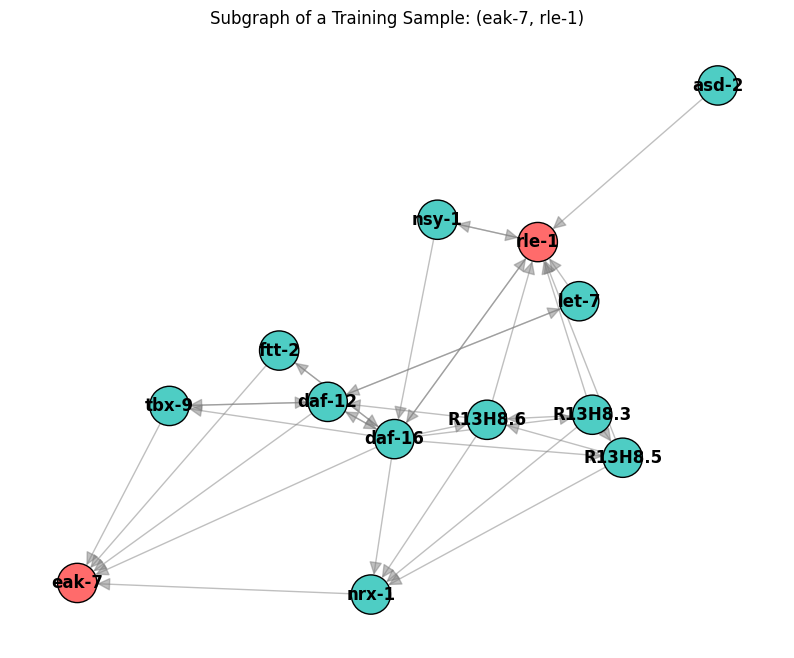

In [78]:
sample = train_dataset[1]
subset_nodes = sample['node_ids']
focal_pair = sample['pair']

edge_index_sub, _ = subgraph(
    subset_nodes,
    data_processed.edge_index,
    relabel_nodes=False
)

G = nx.DiGraph()
G.add_nodes_from(subset_nodes.tolist())
G.add_edges_from(edge_index_sub.t().tolist())

node_colors = []
for node in G.nodes():
    if node in focal_pair.tolist():
        node_colors.append('#ff6b6b')
    else:
        node_colors.append('#4ecdc4')

node_labels = {node: id2node.get(node, node) for node in G.nodes()}
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)

nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=800, edgecolors='black')
nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.5, arrows=True, arrowstyle='-|>',  arrowsize=20, node_size=800)
nx.draw_networkx_labels(G, pos, labels=node_labels, font_color='black', font_weight='bold')
# nx.draw_networkx_labels(G, pos, font_color='black', font_weight='bold')

focal_pair_label = f"({id2node[focal_pair[0].item()]}, {id2node[focal_pair[1].item()]})"
plt.title(f"Subgraph of a Training Sample: {focal_pair_label}")
plt.axis('off')
plt.show()

## Train a model

In [79]:
pert_a_max = data_processed.pair_pert_group_index[1].max().item()
pert_b_max = data_processed.pair_pert_group_index[3].max().item()
pert_padding = max(pert_a_max, pert_b_max) + 1

collate_fn_padding = {
    'node_ids': data.num_nodes,
    'node_perturbations': pert_padding,
    'in_degree': max_degree + 1,
    'out_degree': max_degree + 1,
    'dist_to_u': spd_tensor.max().item() + 1,
    'dist_to_v': spd_tensor.max().item() + 1,
    'pairwise_dist': spd_tensor.max().item() + 1,
    'adj_matrix': data_processed.edge_type.max().item() + 1,
    'average_edge_type_encoding': data_processed.edge_type.max().item() + 1,
    'lifespan_dist': data_processed.lifespan_dist.max().item() + 1
}

graphormer_collate = partial(graphormer_collate_fn, pad_values=collate_fn_padding)

train_dataset = PairSubgraphDataset(train_list)
test_dataset = PairSubgraphDataset(test_list)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=graphormer_collate)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=graphormer_collate)

In [80]:
num_epochs = 70
C = 3

params = {
    'sum_node_features': True,
    'use_pretrained_gene_embs': False,
    'fine_tune_gene_emb': False,
    'fine_tune_ont_emb': False,
    'randomize_labels': False,
    'max_spd': spd_tensor.max().item(),
    # 'max_spd': 3,
    'num_degree_bins': 5,
    'dropout_p': 0.1,
    'd_model': 8,
    'num_heads': 2,
    'num_layers': 6
}

model = RelationalPairClassifierGraphormer(
    graph_data = data_processed,
    params = params
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
                optimizer, T_0=10, T_mult=2, eta_min=0.0
            )
loss_fn = nn.KLDivLoss(reduction='batchmean')

print(f"Synergy Graph Transformer Model Architecture: \n\n{model}")

Synergy Graph Transformer Model Architecture: 

RelationalPairClassifierGraphormer(
  (node_identity_embedding): Embedding(11494, 8, padding_idx=11493)
  (dist_uv_embedding): Embedding(10, 8)
  (in_degree_embedding): Embedding(5, 8)
  (out_degree_embedding): Embedding(5, 8)
  (lifespan_dist_embedding): Embedding(6, 8, padding_idx=5)
  (perturbation_embedding): Embedding(4, 8, padding_idx=3)
  (pairwise_dist_embedding): Embedding(10, 2, padding_idx=9)
  (edge_type_embedding): Embedding(3, 2, padding_idx=2)
  (mutual_interactor_bias_emb): Embedding(2, 2)
  (dist_uv_bias_embedding): Embedding(10, 2)
  (value_projections): ModuleDict(
    (0): Linear(in_features=8, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=8, bias=True)
  )
  (encoder_layers): ModuleList(
    (0-5): 6 x RelationalGTEncoderLayer(
      (value_projections): ModuleDict(
        (0): Linear(in_features=8, out_features=8, bias=True)
        (

In [84]:
# Run this cell only if you want to train from scratch. This will take about 5 mins.
# If not, skip to the next cell and load a pre-trained model.

training_results, test_preds = train_synergy_model(model, train_loader, test_loader, label_name='target_soft_smoothed', optimizer=optimizer, scheduler=scheduler, loss_fn=loss_fn, device=device, randomize_labels=params.get('randomize_labels'), num_epochs=num_epochs, num_classes=C)

Epoch 001


Eval: 100%|██████████| 6/6 [00:00<00:00,  9.52it/s]


lr=0.0009755282581475768  train_loss=0.0704  test_loss=0.0655

Epoch 002


Eval: 100%|██████████| 6/6 [00:00<00:00, 14.40it/s]


lr=0.0009045084971874737  train_loss=0.0582  test_loss=0.0621

Epoch 003


Eval: 100%|██████████| 6/6 [00:00<00:00, 12.68it/s]


lr=0.0007938926261462366  train_loss=0.0575  test_loss=0.0623

Epoch 004


Eval: 100%|██████████| 6/6 [00:00<00:00, 12.90it/s]


lr=0.0006545084971874737  train_loss=0.0582  test_loss=0.0620

Epoch 005


Eval: 100%|██████████| 6/6 [00:00<00:00, 12.08it/s]


lr=0.0005  train_loss=0.0585  test_loss=0.0617

Epoch 006


Eval: 100%|██████████| 6/6 [00:00<00:00, 11.38it/s]


lr=0.00034549150281252633  train_loss=0.0562  test_loss=0.0622

Epoch 007


Eval: 100%|██████████| 6/6 [00:00<00:00, 14.89it/s]


lr=0.00020610737385376348  train_loss=0.0568  test_loss=0.0620

Epoch 008


Eval: 100%|██████████| 6/6 [00:00<00:00, 13.90it/s]


lr=9.549150281252633e-05  train_loss=0.0568  test_loss=0.0618

Epoch 009


Eval: 100%|██████████| 6/6 [00:00<00:00, 15.12it/s]


lr=2.4471741852423235e-05  train_loss=0.0564  test_loss=0.0618

Epoch 010


Eval: 100%|██████████| 6/6 [00:00<00:00, 15.18it/s]


lr=0.001  train_loss=0.0563  test_loss=0.0617

Epoch 011


Eval: 100%|██████████| 6/6 [00:00<00:00, 15.60it/s]


lr=0.0009938441702975688  train_loss=0.0571  test_loss=0.0610

Epoch 012


Eval: 100%|██████████| 6/6 [00:00<00:00, 15.74it/s]


lr=0.0009755282581475768  train_loss=0.0572  test_loss=0.0611

Epoch 013


Eval: 100%|██████████| 6/6 [00:00<00:00, 15.14it/s]


lr=0.0009455032620941839  train_loss=0.0585  test_loss=0.0607

Epoch 014


Eval: 100%|██████████| 6/6 [00:00<00:00, 15.43it/s]


lr=0.0009045084971874737  train_loss=0.0554  test_loss=0.0608

Epoch 015


Eval: 100%|██████████| 6/6 [00:00<00:00, 16.01it/s]


lr=0.0008535533905932737  train_loss=0.0564  test_loss=0.0612

Epoch 016


Eval: 100%|██████████| 6/6 [00:00<00:00, 15.38it/s]


lr=0.0007938926261462366  train_loss=0.0575  test_loss=0.0608

Epoch 017


Eval: 100%|██████████| 6/6 [00:00<00:00, 16.04it/s]


lr=0.0007269952498697733  train_loss=0.0558  test_loss=0.0604

Epoch 018


Eval: 100%|██████████| 6/6 [00:00<00:00, 15.35it/s]


lr=0.0006545084971874737  train_loss=0.0549  test_loss=0.0595

Epoch 019


Eval: 100%|██████████| 6/6 [00:00<00:00, 15.53it/s]


lr=0.0005782172325201155  train_loss=0.0558  test_loss=0.0597

Epoch 020


Eval: 100%|██████████| 6/6 [00:00<00:00, 14.29it/s]


lr=0.0005  train_loss=0.0553  test_loss=0.0594

Epoch 021


Eval: 100%|██████████| 6/6 [00:00<00:00, 15.64it/s]


lr=0.0004217827674798847  train_loss=0.0545  test_loss=0.0589

Epoch 022


Eval: 100%|██████████| 6/6 [00:00<00:00, 14.46it/s]


lr=0.00034549150281252633  train_loss=0.0547  test_loss=0.0586

Epoch 023


Eval: 100%|██████████| 6/6 [00:00<00:00, 15.50it/s]


lr=0.00027300475013022663  train_loss=0.0549  test_loss=0.0584

Epoch 024


Eval: 100%|██████████| 6/6 [00:00<00:00, 15.43it/s]


lr=0.00020610737385376348  train_loss=0.0559  test_loss=0.0584

Epoch 025


Eval: 100%|██████████| 6/6 [00:00<00:00, 15.73it/s]


lr=0.00014644660940672628  train_loss=0.0544  test_loss=0.0588

Epoch 026


Eval: 100%|██████████| 6/6 [00:00<00:00, 15.46it/s]


lr=9.549150281252633e-05  train_loss=0.0539  test_loss=0.0583

Epoch 027


Eval: 100%|██████████| 6/6 [00:00<00:00, 13.98it/s]


lr=5.449673790581611e-05  train_loss=0.0538  test_loss=0.0583

Epoch 028


Eval: 100%|██████████| 6/6 [00:00<00:00, 14.36it/s]


lr=2.4471741852423235e-05  train_loss=0.0552  test_loss=0.0583

Epoch 029


Eval: 100%|██████████| 6/6 [00:00<00:00, 16.11it/s]


lr=6.15582970243117e-06  train_loss=0.0549  test_loss=0.0583

Epoch 030


Eval: 100%|██████████| 6/6 [00:00<00:00, 15.80it/s]


lr=0.001  train_loss=0.0532  test_loss=0.0583

Epoch 031


Eval: 100%|██████████| 6/6 [00:00<00:00, 16.30it/s]


lr=0.000998458666866564  train_loss=0.0564  test_loss=0.0589

Epoch 032


Eval: 100%|██████████| 6/6 [00:00<00:00, 15.80it/s]


lr=0.0009938441702975688  train_loss=0.0566  test_loss=0.0603

Epoch 033


Eval: 100%|██████████| 6/6 [00:00<00:00, 11.02it/s]


lr=0.0009861849601988384  train_loss=0.0543  test_loss=0.0585

Epoch 034


Eval: 100%|██████████| 6/6 [00:00<00:00, 14.83it/s]


lr=0.0009755282581475768  train_loss=0.0544  test_loss=0.0578

Epoch 035


Eval: 100%|██████████| 6/6 [00:00<00:00, 13.15it/s]


lr=0.0009619397662556434  train_loss=0.0538  test_loss=0.0597

Epoch 036


Eval: 100%|██████████| 6/6 [00:00<00:00, 12.66it/s]


lr=0.0009455032620941839  train_loss=0.0548  test_loss=0.0581

Epoch 037


Eval: 100%|██████████| 6/6 [00:00<00:00, 14.44it/s]


lr=0.0009263200821770461  train_loss=0.0546  test_loss=0.0589

Epoch 038


Eval: 100%|██████████| 6/6 [00:00<00:00, 14.59it/s]


lr=0.0009045084971874737  train_loss=0.0532  test_loss=0.0581

Epoch 039


Eval: 100%|██████████| 6/6 [00:00<00:00, 10.52it/s]


lr=0.0008802029828000156  train_loss=0.0518  test_loss=0.0580

Epoch 040


Eval: 100%|██████████| 6/6 [00:00<00:00,  9.28it/s]


lr=0.0008535533905932737  train_loss=0.0535  test_loss=0.0578

Epoch 041


Eval: 100%|██████████| 6/6 [00:00<00:00, 14.43it/s]


lr=0.000824724024165092  train_loss=0.0519  test_loss=0.0568

Epoch 042


Eval: 100%|██████████| 6/6 [00:00<00:00, 10.14it/s]


lr=0.0007938926261462366  train_loss=0.0524  test_loss=0.0566

Epoch 043


Eval: 100%|██████████| 6/6 [00:00<00:00, 14.71it/s]


lr=0.0007612492823579744  train_loss=0.0523  test_loss=0.0573

Epoch 044


Eval: 100%|██████████| 6/6 [00:00<00:00, 14.80it/s]


lr=0.0007269952498697733  train_loss=0.0522  test_loss=0.0566

Epoch 045


Eval: 100%|██████████| 6/6 [00:00<00:00, 13.81it/s]


lr=0.000691341716182545  train_loss=0.0519  test_loss=0.0566

Epoch 046


Eval: 100%|██████████| 6/6 [00:00<00:00, 14.75it/s]


lr=0.0006545084971874737  train_loss=0.0511  test_loss=0.0567

Epoch 047


Eval: 100%|██████████| 6/6 [00:00<00:00, 13.62it/s]


lr=0.0006167226819279528  train_loss=0.0502  test_loss=0.0556

Epoch 048


Eval: 100%|██████████| 6/6 [00:00<00:00, 11.98it/s]


lr=0.0005782172325201155  train_loss=0.0498  test_loss=0.0570

Epoch 049


Eval: 100%|██████████| 6/6 [00:00<00:00, 12.05it/s]


lr=0.0005392295478639225  train_loss=0.0522  test_loss=0.0554

Epoch 050


Eval: 100%|██████████| 6/6 [00:00<00:00, 11.39it/s]


lr=0.0005  train_loss=0.0497  test_loss=0.0560

Epoch 051


Eval: 100%|██████████| 6/6 [00:00<00:00, 14.01it/s]


lr=0.0004607704521360776  train_loss=0.0509  test_loss=0.0553

Epoch 052


Eval: 100%|██████████| 6/6 [00:00<00:00, 14.58it/s]


lr=0.0004217827674798847  train_loss=0.0506  test_loss=0.0561

Epoch 053


Eval: 100%|██████████| 6/6 [00:00<00:00, 12.78it/s]


lr=0.00038327731807204733  train_loss=0.0497  test_loss=0.0557

Epoch 054


Eval: 100%|██████████| 6/6 [00:00<00:00, 13.39it/s]


lr=0.00034549150281252633  train_loss=0.0501  test_loss=0.0553

Epoch 055


Eval: 100%|██████████| 6/6 [00:00<00:00, 12.90it/s]


lr=0.0003086582838174551  train_loss=0.0495  test_loss=0.0557

Epoch 056


Eval: 100%|██████████| 6/6 [00:00<00:00, 14.74it/s]


lr=0.00027300475013022663  train_loss=0.0502  test_loss=0.0550

Epoch 057


Eval: 100%|██████████| 6/6 [00:00<00:00, 15.29it/s]


lr=0.00023875071764202561  train_loss=0.0493  test_loss=0.0552

Epoch 058


Eval: 100%|██████████| 6/6 [00:00<00:00, 11.27it/s]


lr=0.00020610737385376348  train_loss=0.0482  test_loss=0.0548

Epoch 059


Eval: 100%|██████████| 6/6 [00:00<00:00, 11.61it/s]


lr=0.00017527597583490823  train_loss=0.0497  test_loss=0.0547

Epoch 060


Eval: 100%|██████████| 6/6 [00:00<00:00, 15.30it/s]


lr=0.00014644660940672628  train_loss=0.0487  test_loss=0.0544

Epoch 061


Eval: 100%|██████████| 6/6 [00:00<00:00, 13.94it/s]


lr=0.00011979701719998459  train_loss=0.0488  test_loss=0.0546

Epoch 062


Eval: 100%|██████████| 6/6 [00:00<00:00, 15.55it/s]


lr=9.549150281252633e-05  train_loss=0.0486  test_loss=0.0548

Epoch 063


Eval: 100%|██████████| 6/6 [00:00<00:00, 11.99it/s]


lr=7.367991782295391e-05  train_loss=0.0498  test_loss=0.0550

Epoch 064


Eval: 100%|██████████| 6/6 [00:00<00:00, 10.58it/s]


lr=5.449673790581611e-05  train_loss=0.0486  test_loss=0.0549

Epoch 065


Eval: 100%|██████████| 6/6 [00:00<00:00, 11.91it/s]


lr=3.806023374435663e-05  train_loss=0.0492  test_loss=0.0547

Epoch 066


Eval: 100%|██████████| 6/6 [00:00<00:00, 10.94it/s]


lr=2.4471741852423235e-05  train_loss=0.0477  test_loss=0.0546

Epoch 067


Eval: 100%|██████████| 6/6 [00:00<00:00, 11.99it/s]


lr=1.3815039801161721e-05  train_loss=0.0483  test_loss=0.0545

Epoch 068


Eval: 100%|██████████| 6/6 [00:00<00:00,  8.78it/s]


lr=6.15582970243117e-06  train_loss=0.0489  test_loss=0.0545

Epoch 069


Eval: 100%|██████████| 6/6 [00:00<00:00, 11.14it/s]


lr=1.541333133436018e-06  train_loss=0.0485  test_loss=0.0545

Epoch 070


Eval: 100%|██████████| 6/6 [00:00<00:00, 13.60it/s]


lr=0.001  train_loss=0.0493  test_loss=0.0545

Training complete!


Eval: 100%|██████████| 6/6 [00:00<00:00, 14.86it/s]


In [85]:
# # Save the model
# save_path = '../data/demo_model_new.pth'
# torch.save({
#     "state_dict": model.state_dict(),
#     "history": model.history
# }, save_path)
# print(f"Model state and history saved to: {save_path}")

Model state and history saved to: ../data/demo_model_new.pth


In [86]:
saved_model = torch.load('../data/demo_model_new.pth', map_location=device, weights_only=False)
model_loaded = RelationalPairClassifierGraphormer(
    graph_data=data_processed,
    params=params
).to(device)
model_loaded.load_state_dict(saved_model["state_dict"])
model_loaded.history = saved_model.get("history", {})   # safe fallback
# model_loaded.eval()

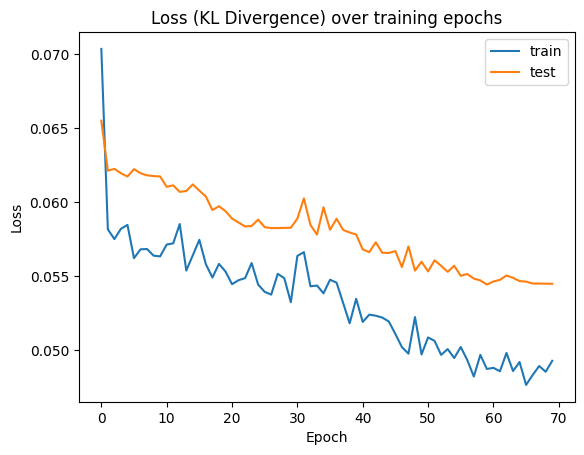

In [87]:
# --- Plot training history ---
plt.plot(model_loaded.history['train_loss'], label="train")
plt.plot(model_loaded.history['test_loss'], label="test")
plt.title("Loss (KL Divergence) over training epochs")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Summarize model performance

In [63]:
model_metrics = model_loaded.history['test_metrics'][0]
mean_baseline_metrics = naive_baseline(model, train_loader, test_loader, loss_fn, baseline_type='mean', smoothed_label=True, C=C)
uninformative_baseline_metrics = naive_baseline(model, train_loader, test_loader, loss_fn, baseline_type='uniform', smoothed_label=True, C=C)

Calculating average distribution on the training data for this fold...
Initializing the naive model with the calculated average...
Evaluating the model on the held-out data...


Eval: 100%|██████████| 6/6 [00:00<00:00, 11.21it/s]


Setting up the uniform distribution baseline...
Initializing the uniform baseline model...
Evaluating the model on the held-out data...


Eval:   0%|          | 0/6 [00:00<?, ?it/s]/Users/bradleybuchner/Desktop/grad_school/research/aging_project/worm_synergy/model/eval.py:84: RuntimeWarning: Mean of empty slice
  return np.nanmean(tau_scores)
Eval: 100%|██████████| 6/6 [00:00<00:00, 24.33it/s]


In [64]:
get_synergy_model_performance(model_metrics, uninformative_baseline_metrics, mean_baseline_metrics)


=== Test Set Model Performance ===

--- Overall Comparison---
                 Model  AUROC (macro)  AUPRC (macro)  Avg. KL Divergence
            Synergy GT           0.72           0.50                0.05
Uninformative Baseline           0.50           0.33                0.11
         Mean Baseline           0.50           0.33                0.06

--- Per-Class AUROC Comparison ---
                        Antagonistic  Neither  Synergistic
Synergy GT                      0.52     0.82         0.84
Uninformative Baseline          0.50     0.50         0.50
Mean Baseline                   0.50     0.50         0.50

--- Per-Class AUPRC Comparison ---
                        Antagonistic  Neither  Synergistic
Synergy GT                      0.06     0.92         0.53
Uninformative Baseline          0.04     0.78         0.18
Mean Baseline                   0.04     0.78         0.18


### Plot predicted synergy probabilities

Eval: 100%|██████████| 6/6 [00:00<00:00, 17.57it/s]


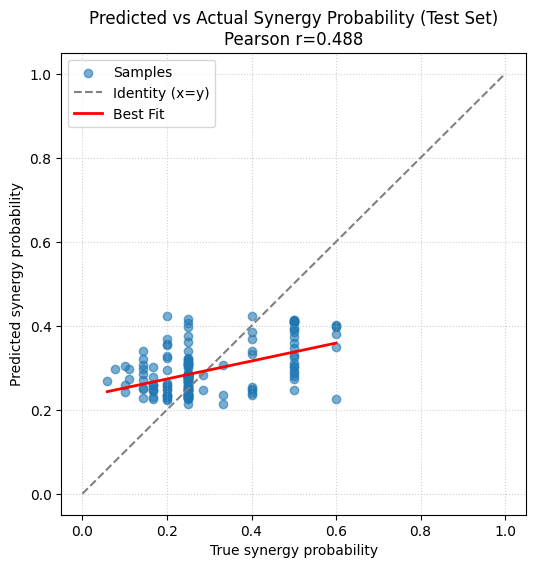

In [65]:
test_preds = get_predictions_synergy_model(model_loaded, test_loader, label_name='target_soft_smoothed', device=device)

preds = np.array(test_preds['preds'])
labels = np.array(test_preds['labels'])

pred_synergy = preds[:, 2]
label_synergy = labels[:, 2]

p_corr, _ = pearsonr(label_synergy, pred_synergy)

m, b = np.polyfit(label_synergy, pred_synergy, 1)
x_fit = np.linspace(label_synergy.min(), label_synergy.max(), 100)
y_fit = m * x_fit + b

plt.figure(figsize=(6, 6))
plt.scatter(label_synergy, pred_synergy, alpha=0.6, label='Samples')
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Identity (x=y)")
plt.plot(x_fit, y_fit, color="red", linestyle="-", linewidth=2, label=f"Best Fit")
plt.xlabel("True synergy probability")
plt.ylabel("Predicted synergy probability")
plt.title(f"Predicted vs Actual Synergy Probability (Test Set)\nPearson r={p_corr:.3f}")
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

## Inspecting the model

### Visualizing the [PAIR] token
Synergy GT relies on what's known as a summarization token to classify pairs of genes based on their joint subgraph. For every gene pair subgraph, a synthetic node called the [PAIR] token (commonly known as the [CLS] token in NLP), is added and given edges connecting it to all other nodes. In the model's attention mechanism, the [PAIR] token is made to attend to all other nodes, but no other nodes attend to it, so its representation can be thought of as a summary of the subgraph. Its representation is used to make the final prediction for a given gene pair, thus the [PAIR] token learns how to best aggregate a subgraph's information such that it is useful for predicting the pair's effect type distribution.

To understand the model's ability to distinguish between pairs that have "synergistic" as the maximum effect type in their effect type distribution from those that do not, visualize the [PAIR] token's representation for every sample in the training data.

Extracting pair representations...
Running t-SNE on 641 pairs...


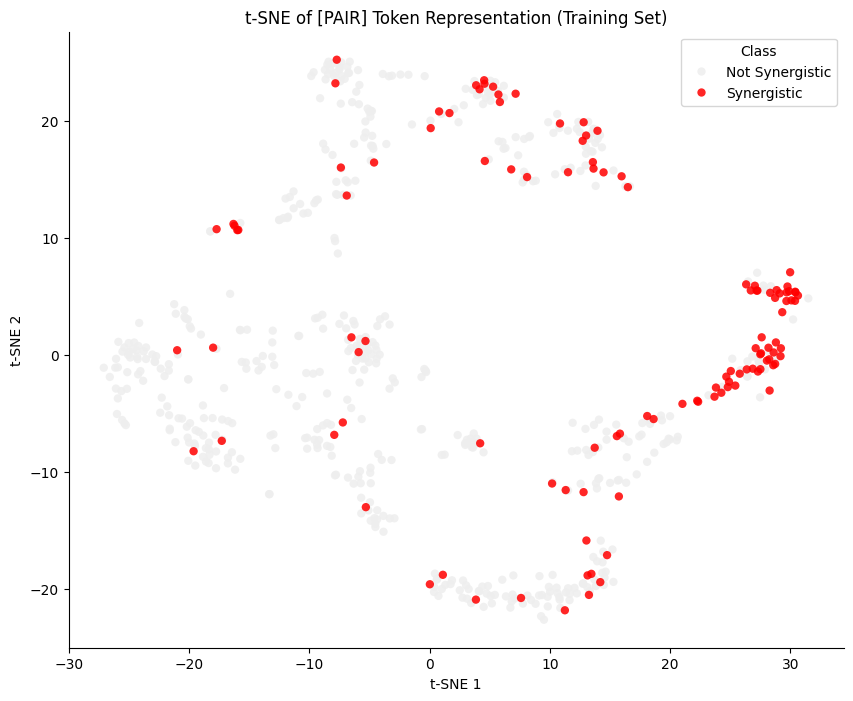

In [66]:
# 1. Visualize the decision space (requires your dataloader)
visualize_synergy_landscape(model_loaded, train_loader, color_by="class", device='mps')

**Observation:** While there isn't a clear decision boundary, [PAIR] tokens for synergistic pairs form a clear grouping.

### Analyzing the most-attended genes
The model's attention mechanism can be used to identify the most attended genes across all subgraphs in the training data. This can be useful for understanding the model's ability to learn which non-focal genes are globally relevant to the prediction task. For example, the model may learn to give additional weight to hub genes that are known lifespan regulators, and thus may be able to predict synergy more accurately for pair subgraphs that contain those genes.

To better understand what genes are globally important to the model, identify genes with the highest average attention given to them by the [PAIR] token and all other tokens when they are NOT one of the two focal nodes (in the pair).

In [24]:
# Analyze top-10 nodes with at least 50 occurrences
analyze_top_attended_nodes(model_loaded, train_loader, id2node, device, top_k=10, min_occurrences=30)

--- Starting Top-10 Node Attention Analysis ---


Scanning Node Attention: 100%|██████████| 21/21 [00:01<00:00, 15.58it/s]


=== Highest Attention from [PAIR] Token (Top 10) ===
Rank  | Node Name/ID                   | Avg Attn     | Occur  | Aging  | In-Deg | Out-Deg
----------------------------------------------------------------------------------------------------
1     | pmk-3 (4467)                   | 0.033190     | 63     | No     | 9      | 26    
2     | sbds-1 (3229)                  | 0.030783     | 48     | No     | 1      | 2     
3     | ced-3 (28)                     | 0.029982     | 31     | No     | 106    | 62    
4     | sin-3 (1072)                   | 0.029852     | 42     | No     | 21     | 147   
5     | cep-1 (3372)                   | 0.027912     | 30     | YES    | 16     | 44    
6     | spg-7 (1489)                   | 0.026702     | 91     | No     | 14     | 61    
7     | ckr-2 (7433)                   | 0.025832     | 48     | YES    | 1      | 2     
8     | odr-1 (3161)                   | 0.025606     | 48     | No     | 2      | 3     
9     | nrx-1 (2038)              

**Observation:** Based on this, the model seems to have learned to give importance to known aging-associated genes. In the first table, 3 of the top 10 most attended to genes have known associations with aging. This is noteworthy because aging-associated genes make up only ~6% of all nodes that occurred at least once in training data subgraphs (181 out of 2943 genes).

TODO:
* comparison of attention to aging vs. non-aging genes
* analysis of dist u/v attn bias